In [1]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import xfads.utils as utils
import xfads.prob_utils as prob_utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL, LowRankNonlinearStateSpaceModel


## ⚙️ 2. Initialize Configuration

We use Hydra to load experiment configs and set up deterministic behavior for reproducibility.

In [2]:
initialize(version_base=None, config_path="", job_name="lds")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()


Seed set to 1234


## 📈 3. Simulate Data

We generate data from a 2D ring attractor latent dynamic system, projecting into 100-dimensional observations using a fixed linear readout.

In [3]:
n_trials = 3000
n_neurons = 100
n_time_bins = 75

mean_fn = utils.RingAttractorDynamics(bin_sz=1e-1, w=0.0)
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)

Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()


## 📈 4. Visualize Latent Trajectories

Let's look at some sample trajectories from the 2D latent space.


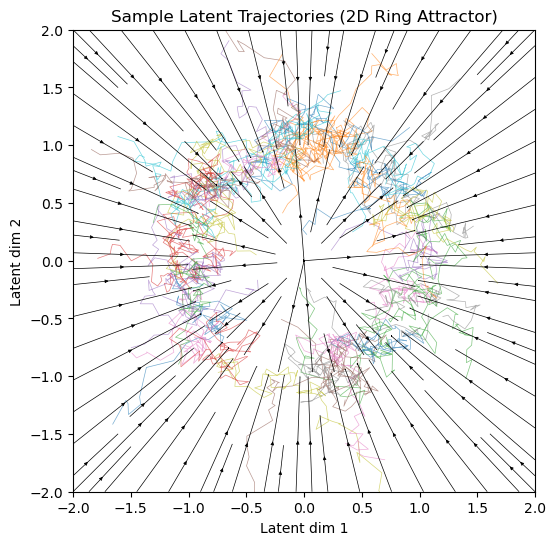

In [44]:
fig, axs = plt.subplots(figsize=(6, 6))
for i in range(40):
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

plot_utils.plot_two_d_vector_field(mean_fn, axs, min_xy=-2, max_xy=2)
axs.set_title("Sample Latent Trajectories (2D Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()

##  5. Prepare Train/Validation Dataloaders

Split the simulated data into training and validation sets and prepare PyTorch dataloaders.


In [17]:
y_train, z_train = y[:2*n_trials//3], z[:2*n_trials//3]
y_valid, z_valid = y[2*n_trials//3:], z[2*n_trials//3:]

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), batch_size=cfg.batch_sz, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), batch_size=cfg.batch_sz, shuffle=True
)

## 🧱 6. Define Model Components

We define the following:
- A Gaussian likelihood with a fixed observation noise
- A nonlinear Gaussian dynamics module
- A prior over the initial condition
- Local and backward encoders for amortized inference

In [18]:
# Likelihood
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)


## 🧠 7. Assemble the State Space Model

We combine dynamics, likelihood, encoders, and filtering into a complete latent variable model.

In [19]:
ssm = LowRankNonlinearStateSpaceModel(
    dynamics_mod, likelihood_pdf, initial_condition_pdf,
    backward_encoder, local_encoder, nl_filter, device=cfg.device
)


## 🔁 8. Train the Model Using PyTorch Lightning

We use `LightningNonlinearSSM` for training. Logging and checkpointing are included.


In [20]:
train_from_scratch = False

if train_from_scratch:
    seq_vae = LightningNonlinearSSM(ssm, cfg)
    
    csv_logger = CSVLogger('logs/', name=f'r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='noncausal')
    ckpt_callback = ModelCheckpoint(
        save_top_k=3, monitor='valid_loss', mode='min',
        dirpath='ckpts/', filename='{epoch:0}_{valid_loss:.2f}'
    )
    
    trainer = pl.Trainer(
        max_epochs=cfg.n_epochs,
        gradient_clip_val=1.0,
        default_root_dir='lightning/',
        callbacks=[ckpt_callback],
        logger=csv_logger
    )
    
    trainer.fit(model=seq_vae, train_dataloaders=train_loader, val_dataloaders=valid_loader)
    torch.save(ckpt_callback.best_model_path, 'ckpts/best_model_path.pt')

else:
    seq_vae = LightningNonlinearSSM.load_from_checkpoint('ckpts/example_model.ckpt', ssm=ssm, cfg=cfg)


## ✅ Done!

The model is now trained. You can proceed with:
- Plotting smoothed trajectories.
- Visualizing uncertainty.
- Comparing inferred vs. ground truth latents (since this was a synthetic dataset).


## 🌀 9. Visualize Learned Dynamics and Simulated Trajectories

Now that training is complete, we can explore what the model has learned.  
This section:
- Seeds the latent space with initial conditions.
- Rolls out the learned dynamics forward in time.
- Overlays those trajectories onto the learned dynamics vector field.
python
Copy
Edit


In [46]:
# Define number of rollout samples and rollout length
n_ex_samples = 1
n_ex_trials = 50
n_ex_time_bins = 50

# Sample initial latent states (z_0): a mix of small and large amplitude noise
z_0 = torch.zeros((n_ex_samples, n_ex_trials, 2))
z_0[:, ::2] = 0.2 * torch.randn_like(z_0[:, ::2])   # small amplitude for even-indexed trials
z_0[:, 1::2] = 2.0 * torch.randn_like(z_0[:, 1::2])  # large amplitude for odd-indexed trials

# Predict forward using the learned dynamics (no encoder or data used here)
z_prd = seq_vae.ssm.predict_forward(z_0, n_ex_time_bins).detach()


### 🧭 Plot: Learned Dynamics Vector Field + Predicted Latent Trajectories

The vector field shows the learned mean dynamics function.
Each curve shows a rollout of the model's latent trajectory starting from a different `z_0`.
    

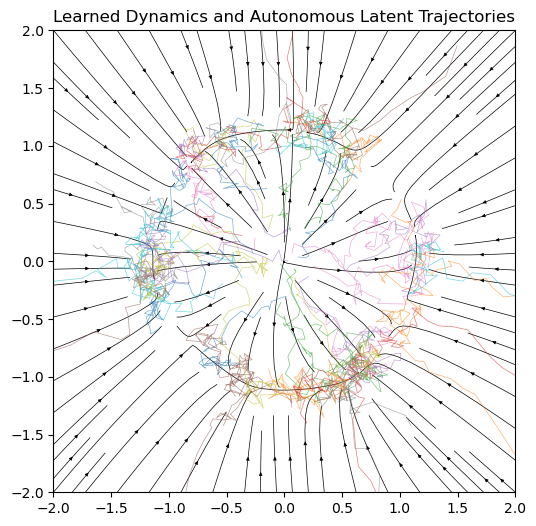

In [47]:
fig, axs = plt.subplots(figsize=(6, 6))
axs.set_box_aspect(1.0)
axs.set_xlim(-2.0, 2.0)
axs.set_ylim(-2.0, 2.0)
axs.set_title("Learned Dynamics and Autonomous Latent Trajectories")

# Plot learned vector field over the 2D latent space
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn,
    axs,
    min_xy=-2,
    max_xy=2,
)

# Overlay predicted trajectories
for i in range(50):  # plot 50 of the 50
    axs.plot(z_prd[0, i, :, 0].cpu(), z_prd[0, i, :, 1].cpu(), lw=0.5, alpha=0.6)

plt.show()
